In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
path = 'data/goodbooks-10k/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train.head()

,user_id,book_id,rating
0,26985,1,5
1,32332,1899,5
2,50054,3114,4
3,33313,2800,4
4,12666,1479,5


In [4]:
train.shape

(4781183, 3)

In [5]:
# drop movies from test that aren't in train
# test = test[test['movieId'].isin(set(train.movieId.unique()))]

In [6]:
n_users = train.user_id.nunique()
n_items = train.book_id.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 53424
Number of items: 10000


In [7]:
max_users = max(train.user_id.max(), test.user_id.max())
max_items = max(train.book_id.max(), test.book_id.max())
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 53423
Max movie ID: 9999


## Predict ratings

In [8]:
checkpoint_path = "models/goodbooks.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

### Trunk of model
We will re-use the item embedding layer later on

In [9]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 25, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 25, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

### Head of model 
#### Option 1: dot product

In [10]:
# # dot product user and item vectors
# prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])

# # create model and compile it
# model = Model([user_input, item_input], prod)
# model.compile('adam', 'mean_squared_error')
# model.summary()

#### Option 2: neural network

In [11]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [12]:
# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=stretch)(d2)

# create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 25)        250000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 25)        1335600     User-Input[0][0]                 
______________________________________________________________________________________________

In [13]:
model.load_weights(checkpoint_path)

Train on 4781183 samples
4780800/4781183 [============================>.] - ETA: 0s - loss: 0.7280
Epoch 00001: saving model to models/goodbooks.ckpt
4781183/4781183 [==============================] - 476s 99us/sample - loss: 0.7280


Text(0, 0.5, 'Training Error')

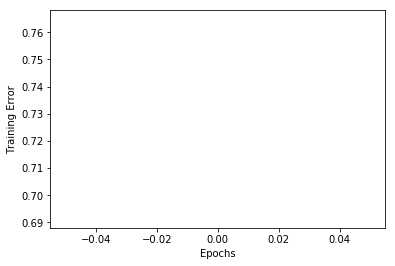

In [14]:
history = model.fit([train.user_id, train.book_id], train.rating, 
                    batch_size=256, 
                    epochs=1, 
                    callbacks=[cp_callback])

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [15]:
model.evaluate([test.user_id, test.book_id], test.rating, batch_size=1024)

1195296/1195296 [==============================] - 6s 5us/sample - loss: 0.7274


0.7273550996868989

In [16]:
np.sqrt(0.7274)

0.8528774824088159

In [17]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.825164] 4
[4.7636757] 5
[3.9167337] 5
[3.3623214] 4
[3.5293412] 3
[3.9413493] 5
[4.2533174] 5
[4.1795506] 5
[3.5952249] 3
[3.8496573] 4


[None, None, None, None, None, None, None, None, None, None]

## Predict genres

In [18]:
books = pd.read_csv(path+'books.csv')
books = books[books['book_id'].isin(set(train.book_id.unique()))]

In [19]:
books.head()

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
0,0,The Hunger Games,eng,0,0,1,1,1,1,1,0,1,1
1,1,Harry Potter and the Philosopher's Stone,eng,0,0,1,0,1,1,1,1,0,1
2,2,Twilight,en-US,0,0,0,1,1,1,1,0,0,1
3,3,To Kill a Mockingbird,eng,1,1,0,1,1,0,1,1,0,1
4,4,The Great Gatsby,eng,1,1,0,1,0,0,1,0,1,1


In [20]:
# check proprtions of each genre
books.iloc[:,3:].agg('sum')/len(books)

adult            0.681176
adult-fiction    0.492522
adventure        0.377617
book-club        0.450232
contemporary     0.545333
fantasy          0.439299
fiction          0.938319
mystery          0.380196
romance          0.438473
young-adult      0.374420
dtype: float64

In [21]:
books.shape

(9695, 13)

In [22]:
# make new genre model
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(10, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 25)             250000    
_________________________________________________________________
Flatten-Items (Flatten)      (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                416       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0   

W0711 15:40:29.596896 12096 deprecation.py:323] From C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9695 samples
Epoch 1/10
9695/9695 [==============================] - 1s 61us/sample - loss: 0.6679 - accuracy: 0.5997
Epoch 2/10
9695/9695 [==============================] - 0s 26us/sample - loss: 0.6350 - accuracy: 0.6275
Epoch 3/10
9695/9695 [==============================] - 0s 21us/sample - loss: 0.6247 - accuracy: 0.6364
Epoch 4/10
9695/9695 [==============================] - 0s 23us/sample - loss: 0.6200 - accuracy: 0.6435
Epoch 5/10
9695/9695 [==============================] - 0s 21us/sample - loss: 0.6167 - accuracy: 0.6470
Epoch 6/10
9695/9695 [==============================] - 0s 23us/sample - loss: 0.6135 - accuracy: 0.6528
Epoch 7/10
9695/9695 [==============================] - 0s 26us/sample - loss: 0.6140 - accuracy: 0.6497
Epoch 8/10
9695/9695 [==============================] - 0s 22us/sample - loss: 0.6118 - accuracy: 0.6523
Epoch 9/10
9695/9695 [==============================] - 0s 25us/sample - loss: 0.6105 - accuracy: 0.6551
Epoch 10/10
9695/9695 [==========

Text(0, 0.5, 'Training Error')

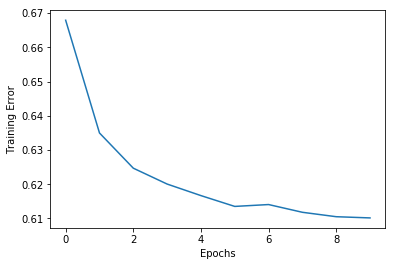

In [23]:
history = model2.fit(books.book_id, books.iloc[:,-10:], batch_size=64, epochs=10)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [24]:
model2.evaluate(books.book_id, books.iloc[:,-10:], batch_size=128)

9695/9695 [==============================] - 0s 17us/sample - loss: 0.6007 - accuracy: 0.6652


[0.6007496963462121, 0.66517776]

In [25]:
# check predictions of first 10 books
np.round(model2.predict(books.book_id.head(10)))

array([[1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Check accuracy for only the romance tag

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [56]:
y_true = books.iloc[:,-10:]
y_score = pd.DataFrame(model2.predict(books.book_id), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [57]:
rom_true = y_true.romance
rom_pred = y_pred.romance

In [58]:
print(classification_report(rom_true, rom_pred))

              precision    recall  f1-score   support

           0       0.64      0.79      0.70      5444
           1       0.61      0.42      0.50      4251

   micro avg       0.63      0.63      0.63      9695
   macro avg       0.62      0.61      0.60      9695
weighted avg       0.62      0.63      0.61      9695



In [59]:
pd.DataFrame(confusion_matrix(rom_true, rom_pred))

,0,1
0,4289,1155
1,2447,1804


In [62]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(rom_true, y_score.iloc[:,-2])

In [63]:
prt_df = pd.DataFrame([thresholds, precision, recall]).T
prt_df.columns = ['threshold','precision','recall']
prt_df.head()

,threshold,precision,recall
0,0.266080,0.439108,1.000000
1,0.266906,0.439050,0.999765
2,0.267017,0.439095,0.999765
3,0.268184,0.439037,0.999530
4,0.268200,0.439082,0.999530


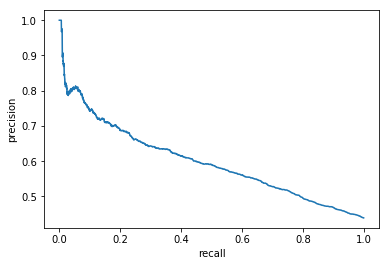

In [64]:
sns.lineplot(x=prt_df.recall,
             y=prt_df.precision)

### Global accuracy

In [65]:
(y_true == y_pred).astype('int').mean()

adult            0.681176
adult-fiction    0.586797
adventure        0.630841
book-club        0.690150
contemporary     0.629293
fantasy          0.621558
fiction          0.938319
mystery          0.619598
romance          0.628468
young-adult      0.625580
dtype: float64

In [66]:
from sklearn.metrics import accuracy_score, coverage_error
# how many perfectly classified rows
accuracy_score(y_true, y_pred)

0.035688499226405365

In [68]:
coverage_error(y_true, y_score)

7.739040742650851

In [69]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

        adult       0.68      1.00      0.81      6604
adult-fiction       0.58      0.58      0.58      4775
    adventure       0.57      0.09      0.15      3661
    book-club       0.66      0.66      0.66      4365
 contemporary       0.63      0.77      0.69      5287
      fantasy       0.61      0.39      0.47      4259
      fiction       0.94      1.00      0.97      9097
      mystery       0.49      0.01      0.02      3686
      romance       0.61      0.42      0.50      4251
  young-adult       0.00      0.00      0.00      3630

    micro avg       0.71      0.59      0.64     49615
    macro avg       0.58      0.49      0.49     49615
 weighted avg       0.63      0.59      0.57     49615
  samples avg       0.71      0.61      0.62     49615



In [70]:
(y_true == y_pred).astype('int').mean().mean()

0.6651779267663744

In [71]:
f1_score(y_true, y_pred, average='micro')

0.6429050746400009

### Precision and Recall

In [72]:
recall_score(y_true, y_pred, average='micro')

0.5640028217273002

In [76]:
precision_score(y_true, y_pred, average='micro')

0.7081793794604444

## Visualise embeddings

In [75]:
item_em = model2.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [76]:
item_em_weights.shape

(10000, 25)

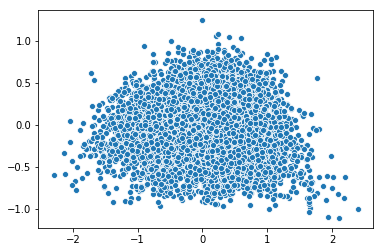

In [77]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [78]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0000001

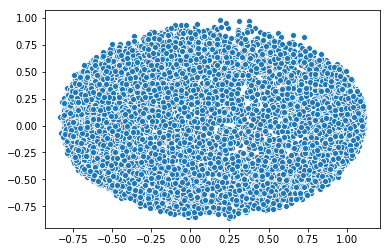

In [79]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [80]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 5.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.189324
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.975891
[t-SNE] KL divergence after 1000 iterations: 2.734298


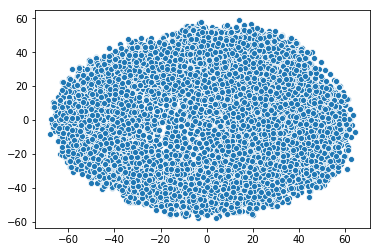

In [81]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [82]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.book_id)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [83]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [84]:
predictions = model.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

# get top 5 predictions
recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([3627, 7946, 8945, 6360, 6589], dtype=int64)

In [85]:
# print predicted scores
predictions[recommended_book_ids]

array([4.955687 , 4.9435205, 4.93825  , 4.9268384, 4.9244685],
      dtype=float32)

In [86]:
books[books['book_id'].isin(recommended_book_ids)]

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
3567,3627,The Complete Calvin and Hobbes,eng,0,0,0,0,0,1,1,0,0,1
6204,6360,There's Treasure Everywhere: A Calvin and Hobb...,eng,1,0,1,0,0,1,1,0,0,1
6420,6589,The Authoritative Calvin and Hobbes,eng,0,0,1,0,0,1,1,0,0,1
7721,7946,NaN,eng,1,0,0,0,0,0,0,0,0,0
8682,8945,دیوان‎‎ [Dīvān],eng,0,0,0,0,0,0,1,0,0,0
